In [1]:
%%html
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
<style>
.rendered_html td {
    font-size: xx-large;
    text-align: left; !important
}
.rendered_html th {
    font-size: xx-large;
    text-align: left; !important
}
</style>

In [2]:
%%capture
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../statnlpbook/")
#import util
import ie
import tfutil
import random
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
np.random.seed(1337)
tf.set_random_seed(1337)

#util.execute_notebook('relation_extraction.ipynb')

<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\a}{\alpha}
\newcommand{\b}{\beta}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

In [3]:
%load_ext tikzmagic

# Relation Extraction

## Schedule

* Motivation: information extraction (10 min.)
* Reminder: named entity recognition (5 min.)
* Background: relation extraction (5 min.)
* Methods: relation extraction (20 min.)
* Relation extraction via reading comprehension (5 min.)
* Break (10 min.)
* Question answering ([slides](question_answering_slides.ipynb))

##  Information Extraction

It would be useful to automatically build a database of this form

<table style="font-size: x-large; border-style: solid;">
<tr><th style="text-align: left; border-style: solid;">Brand</th><th style="text-align: left; border-style: solid;">Parent</th></tr>
<tr><td style="text-align: left; border-style: solid;">KitKat</td><td style="text-align: left; border-style: solid;">Nestle</td></tr>
<tr><td style="text-align: left; border-style: solid;">Lipton</td><td style="text-align: left; border-style: solid;">Unilever</td></tr>
<tr><td style="text-align: left; border-style: solid;">...</td><td style="text-align: left; border-style: solid;">...</td></tr>
</table>

or this graph:
![graph](https://geekologie.com/2012/04/25/parent-companies-large.jpg)

These are all instances of the "[owned by](https://www.wikidata.org/wiki/Property:P127)" relation.
Can also be expressed as:

```
owned_by(KitKat, Nestle)
owned_by(Lipton, Unilever)
```

The web contains a lot of textual evidence for this relation:

> <font color="blue">Dechra Pharmaceuticals</font>, which has just made its second acquisition, had previously purchased <font color="green">Genitrix</font>.

> <font color="blue">Trinity Mirror plc</font>, the largest British newspaper, purchased <font color="green">Local World</font>, its rival.

> <font color="blue">Kraft</font>, owner of <font color="green">Milka</font>, purchased <font color="green">Cadbury Dairy Milk</font> and is now gearing up for a roll-out of its new brand.


... and for many other relations.

```
born_in(Barack Obama, Hawaii)
educated_at(Albert Einstein, University of Zürich)
occupation(Steve Jobs, businessman)
spouse(Angela Merkel, Joachim Sauer)
...
```

### Information Extraction: Motivation

* The amount of available information is vast and still growing quickly
* Text contains a lot of information
* Only some of information is relevant for each use case
* How can we automatically make sense of information?

### Information Extraction: Examples

ReVerb ([Fader et al., 2011](https://www.aclweb.org/anthology/D11-1142.pdf)) demo:

* [who is owned by Nestle?](https://openie.allenai.org/search?arg1=&rel=owned+by&arg2=Nestle&corpora=)
* [whom did Google purchase?](https://openie.allenai.org/search?arg1=Google&rel=purchased&arg2=&corpora=)
* [who invented the computer?](https://openie.allenai.org/search?arg1=who&rel=invented&arg2=the+computer&corpora=)

### Subtasks of Information Extraction

* **Named Entity Recognition (NER)**:
    * Recognise boundaries of entities in text, e.g., "New York", "New York Times"
    * Assign a type to each entity (e.g., "New York" -> LOC, "New York Times" -> ORG)
    * [Sequence labelling task](chapters/sequence_labelling.ipynb)

* **Relation** Extraction:
    * Recognise relations between entities, e.g., "Isabelle Augenstein assoc.prof-at KU"
    * [Classification task](chapters/doc_classify.ipynb)

* **Temporal** Information Extraction:
    * Recognise and/or normalise temporal expressions, e.g., "tomorrow morning at 8" -> "2016-11-26 08:00:00"
    * Sequence labelling or generation task

* **Event** Extraction:
    * Recognise events, typically consisting of entities and relations between them at a point in time and place, e.g., an election
    * Classification task

## Reminder: named entity recognition (NER)

| |
|-|
| \[Barack Obama\]<sub>PER</sub> was born in \[Hawaii\]<sub>LOC</sub> |

| |
|-|
| \[Isabelle Augenstein\]<sub>PER</sub> is an associate professor at the \[University of Copenhagen\]<sub>ORG</sub> |

### NER as sequence labeling with IOB encoding

Label tokens as beginning (B), inside (I), or outside (O) a **named entity:**

| | | | | | |
|-|-|-|-|-|-|
| Barack | Obama | was |  born | in | Hawaii |
| B-PER | I-PER | O |  O | O | B-LOC |


||||||||||
|-|-|-|-|-|-|-|-|-|
| Isabelle | Augenstein | is | an | associate | professor | at | the | University | of | Copenhagen |
| B-PER | I-PER   | O | O | O  | O | O  | O | B-ORG | I-ORG | I-ORG         |


### NER with BiLSTM-CRFs

<center>
  <img src="../img/ner_bilstm_crf.png">
</center>

### Relation Extraction

Task of extracting **semantic relations between arguments**
* Arguments are entities
    * Entity types may be "a company" (ORG), "a person" (PER), "a location" (LOC)
    * Entities are instances of these types (e.g., "Microsoft", "Bill Gates")
* Builds on named entity recognition

### Relation Extraction: Example
   
Step 1: IOB sequence labelling for NER

| Isabelle | Augenstein | is | an | associate | professor | at | the | University | of | Copenhagen |
|-|-|-|-|-|-|-|-|-|
| B-PER | I-PER   | O | O | O  | O | O  | O | B-ORG | I-ORG | I-ORG         |


Step 2: NE decoding
  
  * Isabelle Augenstein: PER  
  * University of Copenhagen: ORG

Step 3: Relation extraction
  
  
| Relation   | Entity 1    |Entity 2    |
|---------|-----------|-----------|
| associate professor at  | Isabelle Augenstein | University of Copenhagen |

### Knowledge Bases

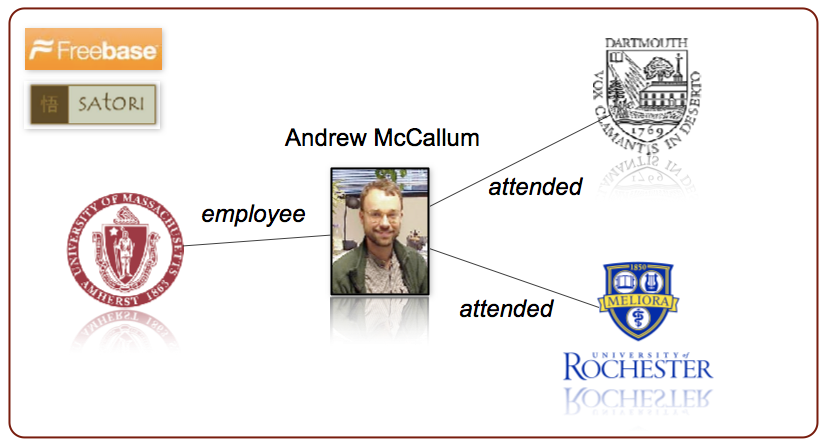

### Relation Extraction for Automated Knowledge Base Construction

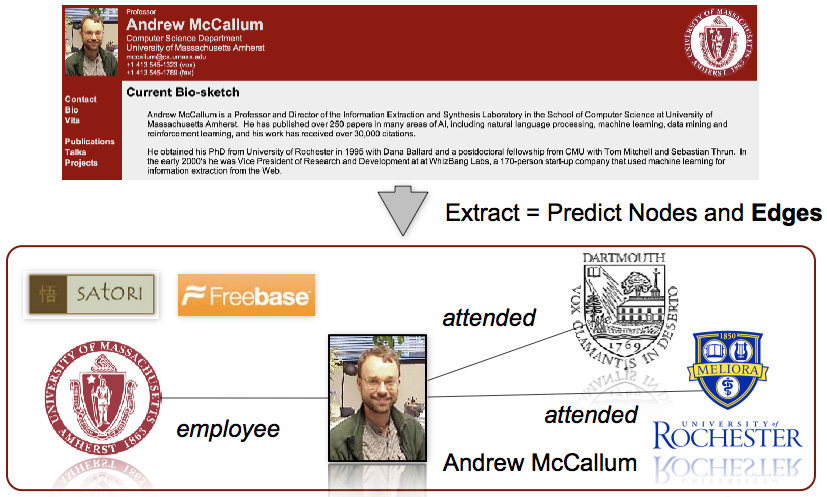

### AKBC: Biomedical Processes

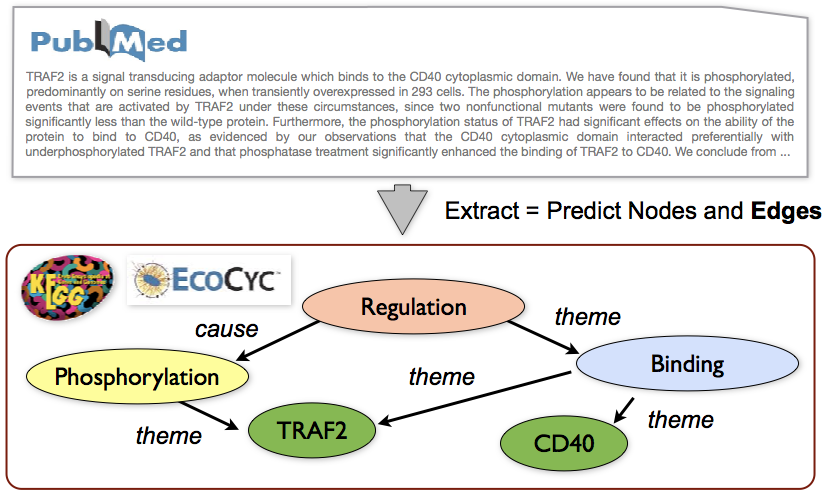

### AKBC: Drug-Gene Interactions

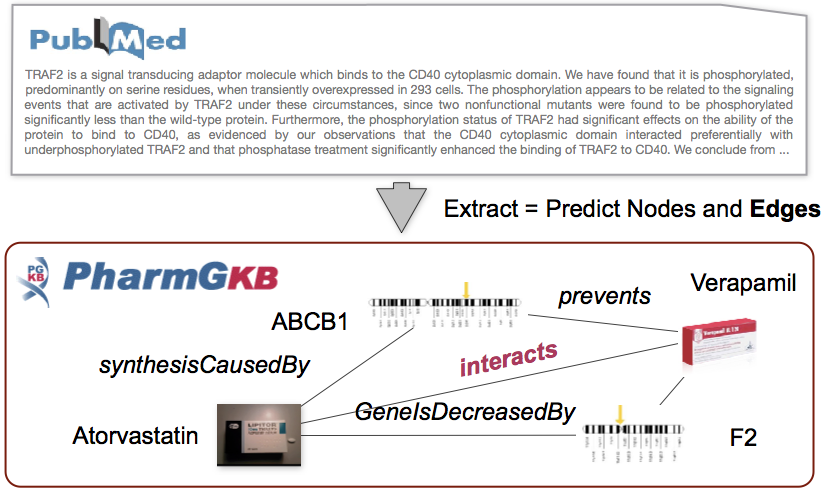

### Existing Knowledge Bases

<center>
  <table>
  <tr>
  <td><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/Wikidata-logo-en.svg/500px-Wikidata-logo-en.svg.png" width="400"></td>
  <td><img src="https://wiki.dbpedia.org/sites/default/files/DBpediaLogoFull.png" width="400"></td>
  <td><img src="https://yago-knowledge.org/assets/images/logo.png" width="400"></td>
  </tr><tr>
  <td><img src="https://content.alegion.com/hubfs/datasets/wordnet.png" width="400"></td>
  <td><img src="https://cst.ku.dk/projekter/dannet/billeder/dannet.png" width="400"></td>
  </tr>
  </table>
</center>

## Relation Extraction as Classification
* Input space $\mathcal{X}$: argument pairs $\in\mathcal{E}$ and supporting texts $\in\mathcal{S}$
  * e.g., ((Isabelle Augenstein, University of Copenhagen), "Isabelle Augenstein is an associate professor at the University of Copenhagen")
* Output space $\mathcal{Y}$: set of relation labels
  * e.g., $\Ys=\{ \text{assoc-prof-at}, \text{founder-of},\text{employee-at},\text{professor-at},\text{NONE}\}$

* **Goal**: train model \\(s_{\params}(\x,y)\\) that assigns high *scores* to a correct label $\mathcal{y}$ for $\mathcal{\x}$, low scores otherwise 
* **Training**: learn parameters \\(\params\\) from training set of $(\mathcal{\x,y})$ pairs
* **Prediction** of labels for input instances $\mathcal{\x}$: solve maximisation problem $\argmax_y s_{\params}(\x,y)$.

<img src="dl-applications-figures/WS_mapping.png" width="100%"/>

<div style="text-align: right;">
    Source: http://ai.stanford.edu/blog/weak-supervision/
</div>

## Relation Extraction Approaches
* **Pattern-Based** Relation Extraction:
    * Extract relations via manually defined textual patterns
* **Bootstrapping**:
    * Iterative pattern-based relation extraction

* **Supervised** Relation Extraction:
    * Train supervised model from manually labelled training examples
* **Distantly Supervised** Relation Extraction:
    * Supervised model with automatically annotated training data

* **Universal Schema** Relation Extraction:
    * Model relation types and surface forms in same semantic space
* **Transfer Learning** for Relation Extraction:
    * Use word or sentence embeddings trained on larger dataset, see representation learning lecture slides ([intro](dl-representations.ipynb), [LMs](language_models_slides.ipynb), [RNNs](rnn_slides_ucph.ipynb), [contextualized representations](dl-representations_contextual.ipynb), [transfer learning](transfer_learning_slides.ipynb))


## Relation Extraction: Running Example
* Extracting `method used for task` relations from sentences in computer science publications
* The first step would normally be to detect pairs of arguments $\mathcal{E}$. For simplicity, our training data already contains those annotations.

Example publications:
* https://www.sciencedirect.com/science/article/pii/S1474034613000475
* https://www.sciencedirect.com/science/article/pii/S1474034613000773
* https://www.sciencedirect.com/science/article/pii/S1474034615000166

## Pattern-Based Extraction
* The simplest relation extraction method
* Set of textual patterns for each relation
* Assign labels to entity pairs whose sentences match that pattern
    * Labels: relation types or `NONE`
* Data: entity pairs $\mathcal{E}$, patterns $A$, labels $Y$

In [4]:
training_patterns, training_entpairs = ie.readLabelledPatternData()
# Training patterns and entity pairs for relation `method used for task`
list(zip(training_patterns[:3], training_entpairs[:3]))

[('demonstrates XXXXX and clustering techniques for XXXXX',
  ['text mining', 'building domain ontology']),
 ('demonstrates text mining and XXXXX for building XXXXX',
  ['clustering techniques', 'domain ontology']),
 ('the XXXXX is able to enhance the XXXXX',
  ['ensemble classifier', 'detection of construction materials'])]

* Patterns: sentences where entity pairs are blanked with placeholder 'XXXXX'
* Here: 
    * Only one relation, `method used for task` (decide between it and `NONE`)
    * Manually defined patterns
* Labels for training data, no labels for test data
* Task: 'predict' labels for test data

In [5]:
testing_patterns, testing_entpairs = ie.readPatternData()
# Testing patterns and entity pairs
list(zip(testing_patterns[0:3], testing_entpairs[:3]))

[('a method for estimation of XXXXX of XXXXX is presented',
  ['effective properties', 'porous materials']),
 ('accounting for XXXXX is essential for estimation of XXXXX',
  ['nonlinear effects', 'effective properties']),
 ('develops the heterogeneous XXXXX for fiber-reinforced XXXXX',
  ['feature model', 'object modeling'])]

### Closer look at pattern matching
* Patterns in the training data: sentences where entity pairs are blanked with `XXXXX`
* Suggested improvement:
    * We could use those patterns to find more sentences
    * However, we are not likely to find many since patterns are very specific to the example
* We need to **generalise** those patterns to less specific ones
    * e.g. define sequence of words between each entity pair as a pattern

In [6]:
def sentence_to_short_pattern(sent):
    """
    Returns the sequence between two arguments in a sentence, where the arguments have been masked
    Args:
        sent: the sentence
    Returns:
        the sequence between to arguments
    """
    sent_toks = sent.split(" ")
    indeces = [i for i, ltr in enumerate(sent_toks) if ltr == "XXXXX"]
    pattern = " ".join(sent_toks[indeces[0]+1:indeces[1]])
    return pattern

print(training_patterns[0])
sentence_to_short_pattern(training_patterns[0])

demonstrates XXXXX and clustering techniques for XXXXX


'and clustering techniques for'

### Revised pattern extraction approach
  * Define sentence shortening / **pattern generalisation method**
  * Apply patterns to testing instances to classify them into `method used for task` and `NONE`

Example: return instances which contain a `method used for task` pattern

In [7]:
def pattern_extraction(training_sentences, testing_sentences):
    """
    Given a set of patterns for a relation, searches for those patterns in other sentences
    Args:
        sent: training sentences with arguments masked, testing sentences with arguments masked
    Returns:
        the testing sentences which the training patterns appeared in
    """
    # convert training and testing sentences to short paths to obtain patterns
    training_patterns = set([sentence_to_short_pattern(train_sent) for train_sent in training_sentences])
    testing_patterns = [sentence_to_short_pattern(test_sent) for test_sent in testing_sentences]
    # look for match of training and testing patterns
    testing_extractions = []
    for i, testing_pattern in enumerate(testing_patterns):
        if testing_pattern in training_patterns: # look for exact matches of patterns
            testing_extractions.append(testing_sentences[i])
    return testing_extractions

pattern_extraction(training_patterns[:300], testing_patterns[:300])

['paper reviews applications of XXXXX in XXXXX',
 'a novel approach was developed to determine the XXXXX in XXXXX',
 'four different types of insoles were examined in terms of their effects on XXXXX in XXXXX',
 'the findings can aid in better understanding the insole design features that could improve XXXXX in XXXXX',
 'this new approach provides more degrees of freedom and XXXXX in XXXXX']

* Problems with approach: 
    * set of patterns has to be defined manually
    * the model does not learn new patterns

* Next: approach which addresses those two shortcomings


## Bootstrapping

* Input: a set of entity pairs
* Overall idea: extract patterns and entity pairs **iteratively**
* One of the first algorithms: [DIPRE (Sergey Brin, 1999)](http://ilpubs.stanford.edu:8090/421/1/1999-65.pdf)
* Two helper methods: 
    * *use entity pairs* to find/generate (more) patterns
    * *apply patterns* to find entity pairs


In [8]:
# use patterns to find more entity pairs
def search_for_entpairs_by_patterns(training_patterns, testing_patterns, testing_entpairs, testing_sentences):
    testing_extractions = []
    appearing_testing_patterns = []
    appearing_testing_entpairs = []
    for i, testing_pattern in enumerate(testing_patterns): # iterate over patterns
        if testing_pattern in training_patterns: # if there is an exact match of a pattern
            testing_extractions.append(testing_sentences[i]) # add the corresponding sentence
            appearing_testing_patterns.append(testing_pattern) # add the pattern
            appearing_testing_entpairs.append(testing_entpairs[i]) # add the entity pairs
    return testing_extractions, appearing_testing_patterns, appearing_testing_entpairs

# use entity pairs to find more patterns
def search_for_patterns_by_entpairs(training_entpairs, testing_patterns, testing_entpairs, testing_sentences):
    testing_extractions = []
    appearing_testing_patterns = []
    appearing_testing_entpairs = []
    for i, testing_entpair in enumerate(testing_entpairs): # iterate over entity pairs
        if testing_entpair in training_entpairs: # if there is an exact match of an entity pair
            testing_extractions.append(testing_sentences[i]) # add the corresponding sentence
            appearing_testing_entpairs.append(testing_entpair) # add the entity pair
            appearing_testing_patterns.append(testing_patterns[i]) # add the pattern
    return testing_extractions, appearing_testing_patterns, appearing_testing_entpairs

The two helper functions are then applied iteratively:

In [9]:
def bootstrapping_extraction(train_sents, train_entpairs, test_sents, test_entpairs, num_iter=10):
    """
    Given a set of patterns and entity pairs for a relation, extracts more patterns and entity pairs iteratively
    Args:
        train_sents: training sentences with arguments masked
        train_entpairs: training entity pairs
        test_sents: testing sentences with arguments masked
        test_entpairs: testing entity pairs
    Returns:
        the testing sentences which the training patterns or any of the inferred patterns appeared in
    """
    # convert training and testing sentences to short paths to obtain patterns
    train_patterns = set([sentence_to_short_pattern(s) for s in train_sents])
    train_patterns.discard("in") # too general, remove this
    test_patterns = [sentence_to_short_pattern(s) for s in test_sents]
    test_extracts = []

    # iteratively get more patterns and entity pairs
    for i in range(1, num_iter):
        print("Number extractions at iteration", str(i), ":", str(len(test_extracts)))
        print("Number patterns at iteration", str(i), ":", str(len(train_patterns)))
        print("Number entpairs at iteration", str(i), ":", str(len(train_entpairs)))
        # get more patterns and entity pairs
        test_extracts_e, ext_test_patterns_e, ext_test_entpairs_e = search_for_patterns_by_entpairs(train_entpairs, test_patterns, test_entpairs, test_sents)
        test_extracts_p, ext_test_patterns_p, ext_test_entpairs_p = search_for_entpairs_by_patterns(train_patterns, test_patterns, test_entpairs, test_sents)
        # add them to the existing patterns and entity pairs for the next iteration
        train_patterns.update(ext_test_patterns_p)
        train_patterns.update(ext_test_patterns_e)
        train_entpairs.extend(ext_test_entpairs_p)
        train_entpairs.extend(ext_test_entpairs_e)
        test_extracts.extend(test_extracts_p)
        test_extracts.extend(test_extracts_e)

    return test_extracts, test_entpairs

In [10]:
test_extracts, test_entpairs = ie.bootstrappingExtraction(training_patterns[:20], training_entpairs[:20], testing_patterns, testing_entpairs, 10)

Number extractions at iteration 0 : 0
Number patterns at iteration 0 : 19
Number entpairs at iteration 0 : 20
Number extractions at iteration 1 : 78
Number patterns at iteration 1 : 19
Number entpairs at iteration 1 : 98
Number extractions at iteration 2 : 239
Number patterns at iteration 2 : 24
Number entpairs at iteration 2 : 259
Number extractions at iteration 3 : 405
Number patterns at iteration 3 : 24
Number entpairs at iteration 3 : 425
Number extractions at iteration 4 : 571
Number patterns at iteration 4 : 24
Number entpairs at iteration 4 : 591
Number extractions at iteration 5 : 737
Number patterns at iteration 5 : 24
Number entpairs at iteration 5 : 757
Number extractions at iteration 6 : 903
Number patterns at iteration 6 : 24
Number entpairs at iteration 6 : 923
Number extractions at iteration 7 : 1069
Number patterns at iteration 7 : 24
Number entpairs at iteration 7 : 1089
Number extractions at iteration 8 : 1235
Number patterns at iteration 8 : 24
Number entpairs at ite

Problem: 
* with each iteration, the number of pattern, entity pairs and extractions increases
* however, they are less correct

In [11]:
train_patterns = set(sentence_to_short_pattern(s) for s in training_patterns[:20])
test_patterns = set(sentence_to_short_pattern(s) for s in test_extracts)

# patterns that do not co-occur with first set of entity pairs
for p in test_patterns:
    if p not in train_patterns:
        print(p)

is firstly introduced in
is higher in
and finally to illustrate the applicability of the proposed method , a
is proposed to plan and execute task in
is introduced in


* One of the reasons is that the semantics of the pattern shifts ("**semantic drift**")
    * Here we try to find new patterns for `method used for task`
    * Many overlapping contexts - imagine the relations `employee-at`, `student-at`

## Supervised Relation Extraction
* Scoring model \\(s_{\params}(\x,y)\\) is estimated based on training sentences $\mathcal{X}$ and their labels $\mathcal{Y}$
* At testing time, predict highest-scoring label for each testing instance: $$ \argmax_{\y\in\Ys} s_{\params}(\x,\y) $$
* Requires both positive (`method used for task`) and negative (`NONE`) training examples

In [12]:
training_sents, training_entpairs, training_labels = ie.readLabelledData()
print("Manually labelled data set consists of", training_labels.count("NONE"), 
          "negative training examples and", training_labels.count("method used for task"), "positive training examples\n")
list(zip(training_sents[21:25], training_entpairs[21:25], training_labels[21:25]))

Manually labelled data set consists of 22 negative training examples and 22 positive training examples



[('a new XXXXX is proposed to solve the XXXXX associated with damage assessment',
  ['dynamic quantum pso algorithm', 'inverse problem'],
  'method used for task'),
 ('XXXXX ( sa ) helps ivs in XXXXX with time constraint',
  ['sensitivity analysis', 'heterogeneous input variables'],
  'NONE'),
 ('this study focused on the XXXXX of XXXXX in images',
  ['automatic detection', 'construction materials'],
  'NONE'),
 ('design of a XXXXX used as XXXXX',
  [" ['case study", 'wind turbine blade'],
  'NONE')]

### Feature extraction
Represent training and testing data as feature vectors.

Typical features:
* Patterns!
* Shortest dependency path between two entities (see [parsing slides](dependency_parsing_slides.ipynb))
* Bag-of-words/n-grams (as in examples coming up; using `sklearn`'s built-in feature extractor)

<center>
    <img src="parsing_figures/dep4re.png" width="60%">
</center>

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

def feat_transform(sents_train, sents_test):
    cv = CountVectorizer()
    cv.fit(sents_train)
    features_train = cv.transform(sents_train)
    features_test = cv.transform(sents_test)
    return features_train, features_test, cv

from sklearn.linear_model import LogisticRegression

def model_train(feats_train, labels):
    model = LogisticRegression(penalty='l2', solver='liblinear')  # logistic regression model with l2 regularisation
    model.fit(feats_train, labels) # fit the model to the transformed training data
    return model

def predict(model, features_test):
    """Find the most compatible output class"""
    preds = model.predict(features_test) # this returns the predicted labels
    return preds

In [14]:
def supervised_extraction(train_sents, train_entpairs, train_labels, test_sents, test_entpairs):
    """
    Given pos/neg training instances, train a logistic regression model with simple BOW features and predict labels on unseen test instances
    Args:
        train_sents: training sentences with arguments masked
        train_entpairs: training entity pairs
        train_labels: labels of training instances
        test_sents: testing sentences with arguments masked
        test_entpairs: testing entity pairs
    Returns:
        predictions for the testing sentences
    """
    # extract short patterns from training and testing sentences
    train_patterns = [sentence_to_short_pattern(test_sent) for test_sent in train_sents]
    test_patterns = [sentence_to_short_pattern(test_sent) for test_sent in test_sents]
    features_train, features_test, cv = feat_transform(train_patterns, test_patterns) # extract features
    model = model_train(features_train, train_labels) # train model
    predictions = predict(model, features_test) # get predictions
    return predictions

In [15]:
testing_preds = supervised_extraction(training_sents, training_entpairs, training_labels, testing_patterns, testing_entpairs)
list(zip(testing_preds, testing_patterns, testing_entpairs))[:10]

[('NONE',
  'a method for estimation of XXXXX of XXXXX is presented',
  ['effective properties', 'porous materials']),
 ('method used for task',
  'accounting for XXXXX is essential for estimation of XXXXX',
  ['nonlinear effects', 'effective properties']),
 ('method used for task',
  'develops the heterogeneous XXXXX for fiber-reinforced XXXXX',
  ['feature model', 'object modeling']),
 ('NONE',
  'two formulations for the problem of optimum XXXXX of onshore XXXXX',
  ['layout design', 'wind farms']),
 ('method used for task',
  'boundary-value and initial-value XXXXX are solved using XXXXX and graph products',
  ['differential equations', 'finite difference method']),
 ('method used for task',
  'boundary-value and initial-value XXXXX are solved using finite difference method and XXXXX',
  ['differential equations', 'graph products']),
 ('method used for task',
  'boundary-value and initial-value differential equations are solved using XXXXX and XXXXX',
  ['finite difference method',

## Distant Supervision
* Supervised learning typically requires large amounts of hand-labelled training examples
* It is **time-consuming and expensive** to manually label examples
    * It is desirable to find ways of automatically or semi-automatically producing more training data
    * We have already seen one example of this, bootstrapping
* Downside of bootstrapping: **semantic drift** 
    * due to the iterative nature of finding good entity pairs and patterns
* Alternative: distant supervision

* We still have a set of entity pairs $\mathcal{E}$, their relation types $\mathcal{Y}$ and a set of sentences $\mathcal{X}$ as an input
    * but we do **not require pre-defined patterns**
* Instead, entity pairs and relations are obtained from a **knowledge resource**, e.g. the [Wikidata knowledge base](https://www.wikidata.org), Yago or Freebase
* Those are used to automatically label all sentences with relations
* Afterwards: supervised learning

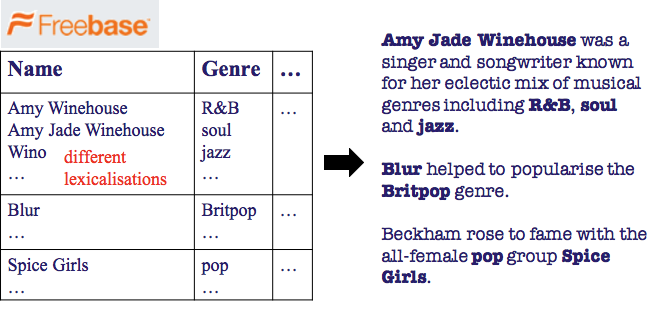

In [16]:
def distantly_supervised_labelling(kb_entpairs, unlab_sents, unlab_entpairs):
    """
    Label instances using distant supervision assumption
    Args:
        kb_entpairs: entity pairs for a specific relation
        unlab_sents: unlabelled sentences with entity pairs anonymised
        unlab_entpairs: entity pairs which were anonymised in unlab_sents

    Returns: pos_train_sents, pos_train_enpairs, neg_train_sents, neg_train_entpairs

    """
    train_sents, train_entpairs, train_labels = [], [], []
    for i, unlab_entpair in enumerate(unlab_entpairs):
        # if the entity pair is a KB tuple, it is a positive example for that relation
        if unlab_entpair in kb_entpairs:  
            train_entpairs.append(unlab_entpair)
            train_sents.append(unlab_sents[i])
            train_labels.append("method used for task")
        else: # else, it is a negative example for that relation
            train_entpairs.append(unlab_entpair)
            train_sents.append(unlab_sents[i])
            train_labels.append("NONE")

    return train_sents, train_entpairs, train_labels

In [17]:
def distantly_supervised_extraction(kb_entpairs, unlab_sents, unlab_entpairs, test_sents, test_entpairs):
    # training_data <- Find training sentences with entity pairs
    train_sents, train_entpairs, train_labels = distantly_supervised_labelling(kb_entpairs, unlab_sents, unlab_entpairs)
    
    print("Distantly supervised labelling results in", train_labels.count("NONE"), 
          "negative training examples and", train_labels.count("method used for task"), "positive training examples")
    
    # training works the same as for supervised RE
    return supervised_extraction(train_sents, train_entpairs, train_labels, test_sents, test_entpairs)

In [18]:
kb_entpairs, unlab_sents, unlab_entpairs = ie.readDataForDistantSupervision()
#print(len(kb_entpairs), "'KB' entity pairs for relation `method used for task` :", kb_entpairs[0:5])
#print(len(unlab_entpairs), 'all entity pairs')
testing_preds = distantly_supervised_extraction(kb_entpairs, unlab_sents, unlab_entpairs, testing_patterns, testing_entpairs)
list(zip(testing_preds, testing_patterns, testing_entpairs))[:10]

Distantly supervised labelling results in 22 negative training examples and 22 positive training examples


[('NONE',
  'a method for estimation of XXXXX of XXXXX is presented',
  ['effective properties', 'porous materials']),
 ('method used for task',
  'accounting for XXXXX is essential for estimation of XXXXX',
  ['nonlinear effects', 'effective properties']),
 ('method used for task',
  'develops the heterogeneous XXXXX for fiber-reinforced XXXXX',
  ['feature model', 'object modeling']),
 ('NONE',
  'two formulations for the problem of optimum XXXXX of onshore XXXXX',
  ['layout design', 'wind farms']),
 ('method used for task',
  'boundary-value and initial-value XXXXX are solved using XXXXX and graph products',
  ['differential equations', 'finite difference method']),
 ('method used for task',
  'boundary-value and initial-value XXXXX are solved using finite difference method and XXXXX',
  ['differential equations', 'graph products']),
 ('method used for task',
  'boundary-value and initial-value differential equations are solved using XXXXX and XXXXX',
  ['finite difference method',

### Limitations of distant supervision

* Overlapping relations
* Ambiguous entities
* Mention vs. type annotations

For example, this relation holds:

`lives-in(Margrethe II of Denmark,  Amalienborg)`

but it would be wrong to attribute it to the sentence

> Margrethe was born 16 April 1940 at Amalienborg

## Universal Schema
* Goal: overcome limitation of pre-defined relations
* Viewing patterns **as relations themselves**


The space of entity pairs and relations is defined by a matrix:

|  | demonstrates XXXXX for XXXXXX | XXXXX is capable of XXXXXX | an XXXXX model is employed for XXXXX | XXXXX decreases the XXXXX | method is used for task |
| ------ | ----------- |
| 'text mining', 'building domain ontology' | 1 |  |  |  | 1 |
| 'ensemble classifier', 'detection of construction materials' |  |  | 1 |  | 1 |
| 'data mining', 'characterization of wireless systems performance'|  | 1 |  |  | ? |
| 'frequency domain', 'computational cost' |  |  |  | 1 | ? |

* `method used for task` is a pre-defined relation, others are patterns
* Co-occurrence is signified by a '1'
* We would like to fill in the '?' cells

Training data:
* **Positive relations and entity pairs** from the annotated data
* **Negative entity pairs and relations** *sampled randomly* from empty cell in the matrix

## Model: Neural Matrix Factorisation for Recommender Systems

<center>
    <img src="dl-applications-figures/neural_mf.png" width=800/> 
</center>

<div style="text-align: right;">
    (from [Zhang et al., 2017](https://arxiv.org/abs/1707.07435))
</div>

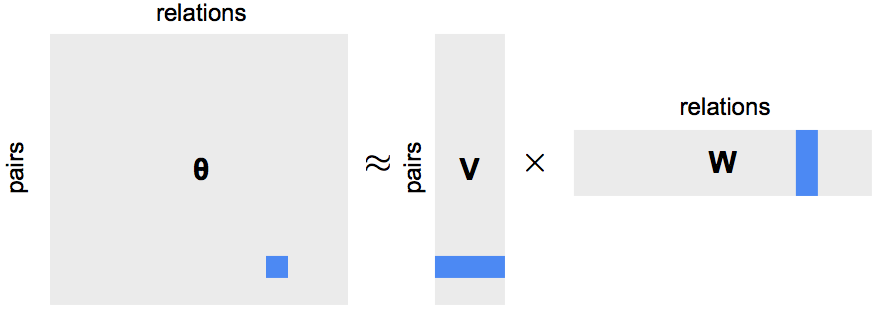

In [19]:
training_sents, training_entpairs, training_labels = ie.readLabelledData() # data reading
pos_train_ids, neg_train_ids = ie.split_labels_pos_neg(training_labels + training_labels) # split positive and negative training data

training_toks_pos = [t.split(" ") for i, t in enumerate(training_sents + training_labels) if i in pos_train_ids]
training_toks_neg = [t.split(" ") for i, t in enumerate(training_sents + training_labels) if i in neg_train_ids]
training_ent_toks_pos = [" || ".join(t).split(" ") for i, t in enumerate(training_entpairs + training_entpairs) if i in pos_train_ids]
training_ent_toks_neg = [" || ".join(t).split(" ") for i, t in enumerate(training_entpairs + training_entpairs) if i in neg_train_ids]
testing_ent_toks = [" || ".join(t).split(" ") for t in testing_entpairs]

# vectorise data (assign IDs to words)
count_rels, dictionary_rels, reverse_dictionary_rels = ie.build_dataset(
        [token for senttoks in training_toks_pos + training_toks_neg for token in senttoks])
count_ents, dictionary_ents, reverse_dictionary_ents = ie.build_dataset(
        [token for senttoks in training_ent_toks_pos + training_ent_toks_neg for token in senttoks])

# transform sentences to IDs, pad vectors for each sentence so they have same length
lens_rel = [len(s) for s in training_toks_pos + training_toks_neg]
lens_ents = [len(s) for s in training_ent_toks_pos + training_ent_toks_neg + testing_ent_toks]
rels_train_pos = [ie.transform_dict(dictionary_rels, senttoks, max(lens_rel)) for senttoks in training_toks_pos]
rels_train_neg = [ie.transform_dict(dictionary_rels, senttoks, max(lens_rel)) for senttoks in training_toks_neg]
ents_train_pos = [ie.transform_dict(dictionary_ents, senttoks, max(lens_ents)) for senttoks in training_ent_toks_pos]
ents_train_neg = [ie.transform_dict(dictionary_ents, senttoks, max(lens_ents)) for senttoks in training_ent_toks_neg]

# Negatively sample some entity pairs for training. Here we have some manually labelled neg ones, so we can sample from them.
ents_train_neg_samp = [random.choice(ents_train_neg) for _ in rels_train_neg]
ents_test_pos = [ie.transform_dict(dictionary_ents, senttoks, max(lens_ents)) for senttoks in testing_ent_toks]
# Sample those test entity pairs from the training ones as for those we have neg annotations
ents_test_neg_samp = [random.choice(ents_train_neg) for _ in ents_test_pos]  

vocab_size_rels = len(dictionary_rels)
vocab_size_ents = len(dictionary_ents) 

# for testing, we want to check if each unlabelled instance expresses the given relation "method for task"
rels_test_pos = [ie.transform_dict(dictionary_rels, training_toks_pos[-1], max(lens_rel)) for _ in testing_patterns]
rels_test_neg_samp = [random.choice(rels_train_neg) for _ in rels_test_pos]

data = ie.vectorise_data(training_sents, training_entpairs, training_labels, testing_patterns, testing_entpairs)

rels_train_pos, rels_train_neg, ents_train_pos, ents_train_neg_samp, rels_test_pos, rels_test_neg_samp, \
    ents_test_pos, ents_test_neg_samp, vocab_size_rels, vocab_size_ents, max_lens_rel, max_lens_ents, \
    dictionary_rels_rev, dictionary_ents_rev = data

# setting hyper-parameters
batch_size = 4
repr_dim = 30 # dimensionality of relation and entity pair vectors
learning_rate = 0.001
max_epochs = 31

# Placeholders (empty Tensorflow variables) for positive and negative relations and entity pairs
# In each training epoch, for each batch, those will be set through mini batching

relations_pos = tf.placeholder(tf.int32, [None, max_lens_rel], name='relations_pos')  # [batch_size, max_rel_seq_len]
relations_neg = tf.placeholder(tf.int32, [None, max_lens_rel], name='relations_neg')  # [batch_size, max_rel_seq_len]

ents_pos = tf.placeholder(tf.int32, [None, max_lens_ents], name="ents_pos") # [batch_size, max_ent_seq_len]
ents_neg = tf.placeholder(tf.int32, [None, max_lens_ents], name="ents_neg") # [batch_size, max_ent_seq_len]

# Creating latent representations of relations and entity pairs
# latent feature representation of all relations, which are initialised randomly
relation_embeddings = tf.Variable(tf.random_uniform([vocab_size_rels, repr_dim], -0.1, 0.1, dtype=tf.float32),
                                   name='rel_emb', trainable=True)

# latent feature representation of all entity pairs, which are initialised randomly
ent_embeddings = tf.Variable(tf.random_uniform([vocab_size_ents, repr_dim], -0.1, 0.1, dtype=tf.float32),
                                      name='cand_emb', trainable=True)

# look up latent feature representation for relations and entities in current batch
rel_encodings_pos = tf.nn.embedding_lookup(relation_embeddings, relations_pos)
rel_encodings_neg = tf.nn.embedding_lookup(relation_embeddings, relations_neg)

ent_encodings_pos = tf.nn.embedding_lookup(ent_embeddings, ents_pos)
ent_encodings_neg = tf.nn.embedding_lookup(ent_embeddings, ents_neg)

# our feature representation here is a vector for each word in a relation or entity 
# because our training data is so small
# we therefore take the sum of those vectors to get a representation of each relation or entity pair
rel_encodings_pos = tf.reduce_sum(rel_encodings_pos, 1)  # [batch_size, num_rel_toks, repr_dim]
rel_encodings_neg = tf.reduce_sum(rel_encodings_neg, 1)  # [batch_size, num_rel_toks, repr_dim]

ent_encodings_pos = tf.reduce_sum(ent_encodings_pos, 1)  # [batch_size, num_ent_toks, repr_dim]
ent_encodings_neg = tf.reduce_sum(ent_encodings_neg, 1)  # [batch_size, num_ent_toks, repr_dim]

# measuring compatibility between positive entity pairs and relations
# used for ranking test data
dotprod_pos = tf.reduce_sum(tf.multiply(ent_encodings_pos, rel_encodings_pos), 1)

# measuring compatibility between negative entity pairs and relations
dotprod_neg = tf.reduce_sum(tf.multiply(ent_encodings_neg, rel_encodings_neg), 1)

# difference in dot product of positive and negative instances
# used for BPR loss (ranking loss)
diff_dotprod = tf.reduce_sum(tf.multiply(ent_encodings_pos, rel_encodings_pos) - tf.multiply(ent_encodings_neg, rel_encodings_neg), 1)


Final vocab size: 163
Final vocab size: 138
Max relation length: 16
Max entity pair length: 9
Final vocab size: 163
Final vocab size: 138


Loss: maximise distance between the positive and negative instances

$$\mathcal{\sum -  \log(v_{e_{pos}} \cdot a_{r_{pos}})} + {\sum \log(v_{e_{neg}} \cdot a_{r_{neg}})}$$

Now that we have read in the data, vectorised it and created the universal schema relation extraction model, let's start training

In [20]:
# create the model / Tensorflow computation graph
dotprod_pos, dotprod_neg, diff_dotprod, placeholders = ie.create_model_f_reader(max_lens_rel, max_lens_ents, repr_dim, vocab_size_rels,
                          vocab_size_ents)

# logistic loss
loss = tf.reduce_sum(tf.nn.softplus(-dotprod_pos)+tf.nn.softplus(dotprod_neg))

data = [np.asarray(rels_train_pos), np.asarray(rels_train_neg), np.asarray(ents_train_pos), np.asarray(ents_train_neg_samp)]
data_test = [np.asarray(rels_test_pos), np.asarray(rels_test_neg_samp), np.asarray(ents_test_pos), np.asarray(ents_test_neg_samp)]

# define an optimiser. Here, we use the Adam optimiser
optimizer = tf.train.AdamOptimizer(learning_rate)
    
# training with mini-batches
batcher = tfutil.BatchBucketSampler(data, batch_size)
batcher_test = tfutil.BatchBucketSampler(data_test, 1, test=True)

with tf.Session() as sess:
    trainer = tfutil.Trainer(optimizer, max_epochs)
    trainer(batcher=batcher, placeholders=placeholders, loss=loss, session=sess)

    # we obtain test scores
    test_scores = trainer.test(batcher=batcher_test, placeholders=placeholders, model=tf.nn.sigmoid(dotprod_pos), session=sess)

Epoch  1 	Loss  53.11272859573364
Epoch  2 	Loss  40.50460696220398
Epoch  3 	Loss  31.24713945388794
Epoch  4 	Loss  24.058605074882507
Epoch  5 	Loss  17.75257933139801
Epoch  6 	Loss  13.676397264003754
Epoch  7 	Loss  10.506169497966766
Epoch  8 	Loss  7.549997687339783
Epoch  9 	Loss  6.212332338094711
Epoch  10 	Loss  5.04358983039856
Epoch  11 	Loss  4.006999537348747
Epoch  12 	Loss  3.2603053152561188
Epoch  13 	Loss  2.6340380758047104
Epoch  14 	Loss  2.1575410664081573
Epoch  15 	Loss  1.7965537309646606
Epoch  16 	Loss  1.615551583468914
Epoch  17 	Loss  1.4916696399450302
Epoch  18 	Loss  1.240600325167179
Epoch  19 	Loss  1.1110371351242065
Epoch  20 	Loss  0.9509495869278908
Epoch  21 	Loss  0.894762460142374
Epoch  22 	Loss  0.7767390683293343
Epoch  23 	Loss  0.7147475983947515
Epoch  24 	Loss  0.6345311086624861
Epoch  25 	Loss  0.5917699486017227
Epoch  26 	Loss  0.5399498473852873
Epoch  27 	Loss  0.5118373408913612
Epoch  28 	Loss  0.49578461796045303
Epoch  29 	L

Test prediction probabilities are obtained by scoring each test instances with:

$$\mathcal{ \sigma  ( v_{e} \cdot a_{r} )}$$

In [21]:
# show predictions
ents_test = [ie.reverse_dict_lookup(dictionary_ents_rev, e) for e in ents_test_pos]
rels_test = [ie.reverse_dict_lookup(dictionary_rels_rev, r) for r in rels_test_pos]
testresults = sorted(zip(test_scores, ents_test, rels_test), key=lambda t: t[0], reverse=True)  # sort for decreasing score

print("\nTest predictions by decreasing probability:")
for score, tup, rel in testresults[:10]:
    print('%f\t%s\t%s' % (score, " ".join(tup), " ".join(rel)))


Test predictions by decreasing probability:
0.999735	UNK optimization problem || optimal UNK UNK problem	method used for task
0.999711	UNK optimization problem || UNK optimization problem	method used for task
0.999117	optimal UNK || hybrid optimization method	method used for task
0.999073	UNK swarm optimization || local search	method used for task
0.998582	UNK swarm optimization || search algorithm	method used for task
0.998582	UNK search algorithm || UNK swarm optimization	method used for task
0.998456	UNK detection || UNK swarm optimization method	method used for task
0.998432	optimization problem || UNK problem	method used for task
0.998391	hybrid algorithm || UNK swarm optimization	method used for task
0.998229	UNK model || supply chain problem	method used for task


## Summary so far

Various relation extraction techniques:
* Pattern-based extraction
* Bootstrapping
* Supervised
* Distantly supervised extraction
* Universal schema

Features often a mix of 
* Syntax-based (relation path)
* Representation learning based (word/sentence embedding)

## Relation extraction via reading comprehension

&nbsp;

<center>
    <a href="slides/zeroshot-relation-extraction-via-reading-comprehension-conll-2017.pdf">
    <img src="https://d3i71xaburhd42.cloudfront.net/fa025e5d117929361bcf798437957762eb5bb6d4/4-Figure2-1.png" width="100%">
    </a>
</center>

<div style="text-align: right;">
    (from [Levy et al., 2017](https://www.aclweb.org/anthology/K17-1034.pdf); [slides](https://levyomer.files.wordpress.com/2017/08/zeroshot-relation-extraction-via-reading-comprehension-conll-2017.pptx))
</div>

## Background Material

* Jurafky, Dan and Martin, James H. (2016). Speech and Language Processing, Chapter 18 (Information Extraction): https://web.stanford.edu/~jurafsky/slp3/18.pdf

* Riedel, Sebastian and Yao, Limin and McCallum, Andrew and Marlin, Benjamin M. (2013). Relation extraction with Matrix Factorization and Universal Schemas. Proceedings of NAACL.  http://www.aclweb.org/anthology/N13-1008

## Further Reading

* Shwartz, V., Goldberg, Y., & Dagan, I. (2016). Improving Hypernymy Detection with an Integrated Path-based and Distributional Method. Proceedings of ACL. https://www.aclweb.org/anthology/P16-1226.pdf
    * Slides: https://vered1986.github.io/papers/ACL_hypernymy.pdf
* Levy, O., Seo, M., Choi, E., & Zettlemoyer, L. (2017). Zero-Shot Relation Extraction via Reading Comprehension. Proceedings of CoNLL.  https://www.aclweb.org/anthology/K17-1034.pdf
* Quan Wang, Zhendong Mao, Bin Wang, and Li Guo (2017). Knowledge Graph Embedding: A Survey of Approaches and Applications. https://persagen.com/files/misc/Wang2017Knowledge.pdf
    * Have a look at this for more scoring functions for universal schema relation extraction
* Shantanu Kumar (2017). A Survey of Deep Learning Methods for Relation Extraction. https://arxiv.org/pdf/1705.03645.pdf
* Alex Ratner, Stephen Bach, Paroma Varma, Chris Ré (2018). Weak Supervision: The New Programming Paradigm for Machine Learning. https://dawn.cs.stanford.edu/2017/07/16/weak-supervision/
    * Have a look at this for details on weak supervision and pointers to methods for learning with limited labelled data
* Rosenman, Shachar, Alon Jacovi, and Yoav Goldberg (2020). Exposing Shallow Heuristics of Relation Extraction Models with Challenge Data. Proceedings of EMNLP. https://arxiv.org/pdf/2010.03656.pdf
* Awesome relation extraction, curated list of resources on relation extraction. https://github.com/roomylee/awesome-relation-extraction